# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 

In this project, I wrote a pipeline to find lane lines on the road. I tested each step of the pipeline and on the videos, (including a video that I took).

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os, glob
%matplotlib inline

## Display the Test Images

Let's start with taking a look at the test images. Tn the images, the lane markers are either white or yellow.

In [2]:
def display_images(images, cmap=None):
    cols = 3
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(12, 5))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

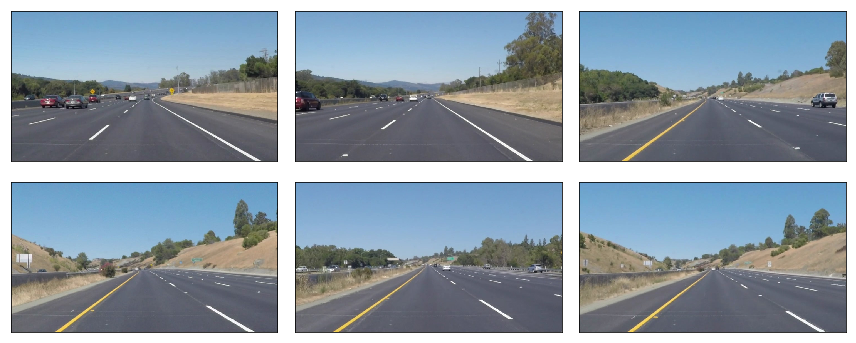

In [3]:
test_images = [plt.imread(test_image) for test_image in glob.glob('test_images/*.jpg')]

display_images(test_images)

## Step 1: Color Selection

We assume that lane lines are either yellow or white. So, we mask out everything that isn't these two colors. I used the same parameters that I used in the Quiz on color selection.

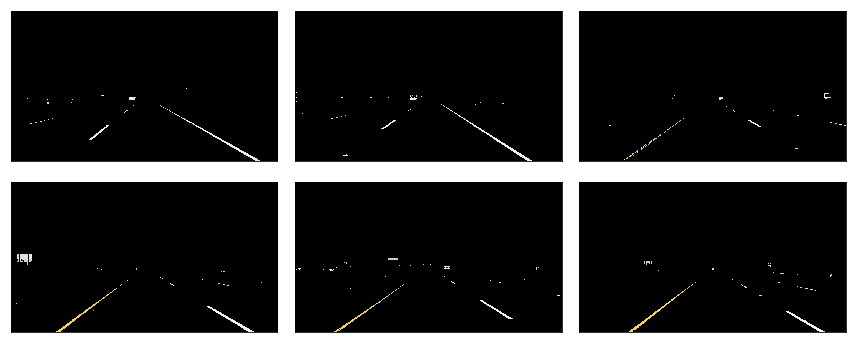

In [4]:
def select_lane_colors(image):
    # white color mask
    low = np.uint8([200,200,200])
    high = np.uint8([255,255,255])
    white_mask = cv2.inRange(image, low, high)
    # yellow (255, 255, 0)
    low = np.uint8([200,200,0])
    high = np.uint8([255,255,255])
    yellow_mask = cv2.inRange(image, low, high)
    white_yellow_mask = cv2.bitwise_or(white_mask, yellow_mask)
    return cv2.bitwise_and(image, image, mask = white_yellow_mask)

color_mask_images = list(map(select_lane_colors, test_images))
display_images(color_mask_images)
    

## Step 2: Region of Interest selection

In this step, we pick a polygon that represents the part of the image where we expect to see lane markers.

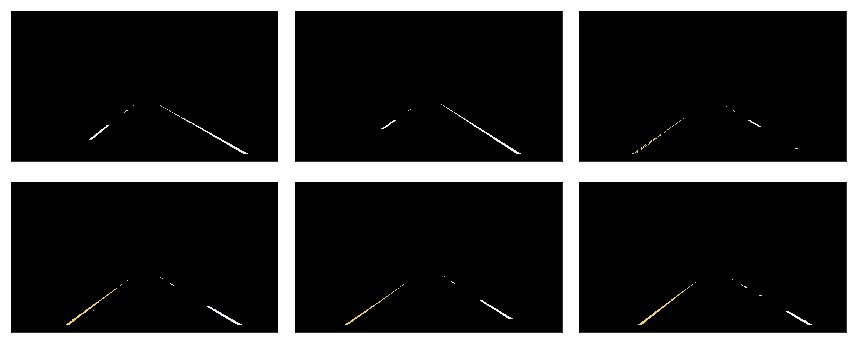

In [5]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #define a blank mask to start with
    mask = np.zeros_like(img)   
    
    #define a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2] 
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #fill pixels inside the polygon   
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #mask out the parts of the image that we don't care about
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def select_region(image):
    
    # first, define the polygons by vertices
    rows, cols = image.shape[:2]
    bottom_left  = [cols*0.05, rows*0.95]
    top_left     = [cols*0.4, rows*0.6]
    bottom_right = [cols*0.95, rows*0.95]
    top_right    = [cols*0.6, rows*0.6] 
    
    # the vertices are an array of polygons
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return region_of_interest(image, vertices)

cropped_images = list(map(select_region, color_mask_images))
display_images(cropped_images)

## Step 3: Convert to Grayscale

Before we do edge detection, we need to convert the image to grayscale.

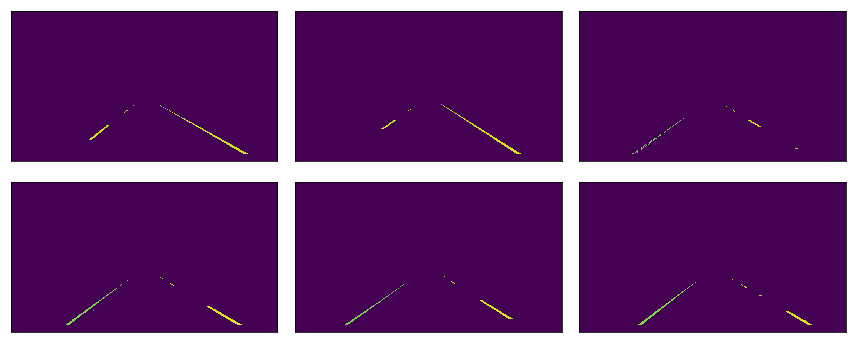

In [6]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

grayscale_images = list(map(grayscale, cropped_images))
display_images(grayscale_images)

## Step 4: Apply Gaussian Smoothing and Canny Edge Detection

We apply Gaussian smoothing and Canny Edge detection. The output shows the edges that were detected in the region of interest.

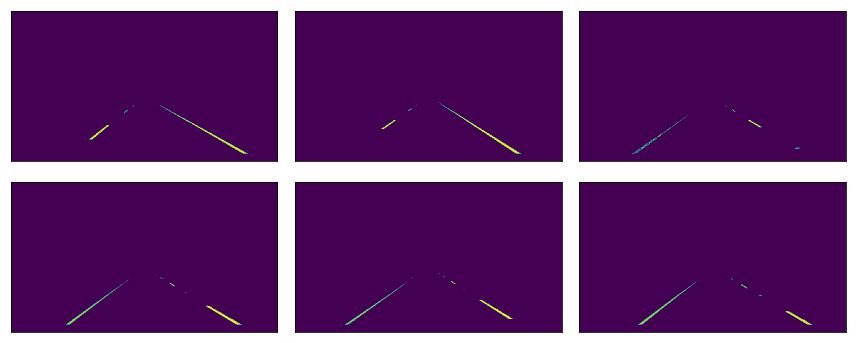

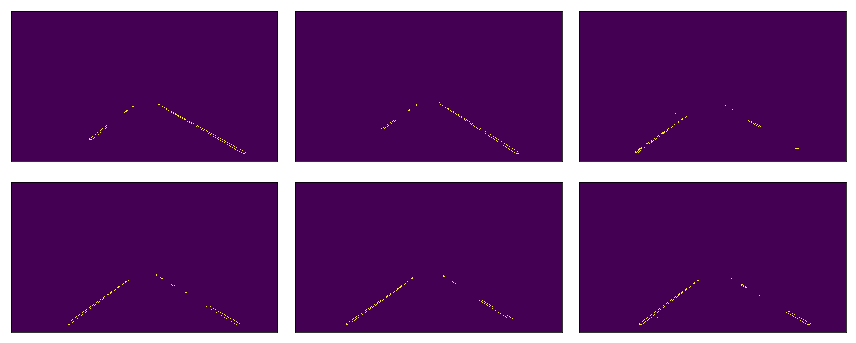

In [7]:
# Define a kernel size for Gaussian smoothing / blurring
# Note: this step is optional as cv2.Canny() applies a 5x5 Gaussian internally

def gaussian_smoothing(gray):
    kernel_size = 3
    return cv2.GaussianBlur(gray,(kernel_size, kernel_size), 0)

smoothed_images = list(map(lambda image: gaussian_smoothing(image), grayscale_images))
display_images(smoothed_images)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

edge_detected_images = list(map(lambda image: canny(image, 50, 150), smoothed_images))
display_images(edge_detected_images)

## Step 5: Implement the Hough transform, and draw lines based on the detected edges on top of the original images.

For this, we detect the best lines that represent lane markers based on expecting the left line to have positive slope, and the right line to have negative slope.

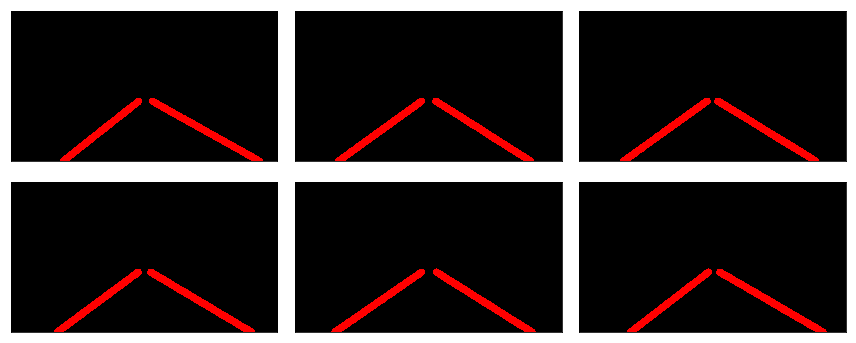

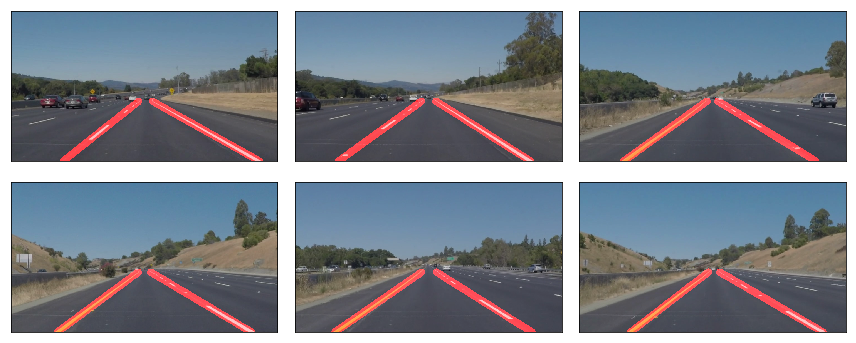

In [8]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=25):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """

    draw_right = True
    draw_left = True
    
    # Lanes have a width and so the slope of the line is likely to be greater than some threshold
    slope_threshold = 0.5
    slopes = []
    new_lines = []
    for line in lines:
        x1, y1, x2, y2 = line[0]  # line = [[x1, y1, x2, y2]]
        
        # Calculate the slope
        if x2 - x1 == 0.:  
            slope = 1000. # some large number
        else:
            slope = (y2 - y1) / (x2 - x1)
            
        # Filter lines based on slope
        if abs(slope) > slope_threshold:
            slopes.append(slope)
            new_lines.append(line)
        
    lines = new_lines
    
    # Split lines into left_lines and right_lines, representing the left and right lane lines
    right_lines = []
    left_lines = []
    for i, line in enumerate(lines):
        x1, y1, x2, y2 = line[0]
        img_x_center = img.shape[1] / 2  # x coordinate of center of image
        if slopes[i] > 0 and x1 > img_x_center and x2 > img_x_center:
            left_lines.append(line)
        elif slopes[i] < 0 and x1 < img_x_center and x2 < img_x_center:
            right_lines.append(line)
            
    # Run a linear regression to find best fit line for left and right lane lines
    # Right lane lines
    right_lines_x = []
    right_lines_y = []
    
    for line in right_lines:
        x1, y1, x2, y2 = line[0]
        
        right_lines_x.append(x1)
        right_lines_y.append(y1)
        
        right_lines_x.append(x2)    
        right_lines_y.append(y2)
        
    if len(right_lines_x) > 0:
        right_m, right_b = np.polyfit(right_lines_x, right_lines_y, 1)  # y = m*x + b
    else:
        right_m, right_b = 1, 1
        draw_right = False
        
    # Left lane lines
    left_lines_x = []
    left_lines_y = []
    
    for line in left_lines:
        x1, y1, x2, y2 = line[0]
        
        left_lines_x.append(x1)
        left_lines_x.append(x2)
        
        left_lines_y.append(y1)
        left_lines_y.append(y2)
        
    if len(left_lines_x) > 0:
        left_m, left_b = np.polyfit(left_lines_x, left_lines_y, 1)  # y = m*x + b
    else:
        left_m, left_b = 1, 1
        draw_left = False
    
    # Find 2 end points for right and left lines, used for drawing the line
    # y = m*x + b => x = (y - b)/m
    y1 = img.shape[0]
    y2 = img.shape[0] * (1 - 0.4)
    
    right_x1 = (y1 - right_b) / right_m
    right_x2 = (y2 - right_b) / right_m
    
    left_x1 = (y1 - left_b) / left_m
    left_x2 = (y2 - left_b) / left_m
    
    # Convert end points from float to int
    y1 = int(y1)
    y2 = int(y2)
    right_x1 = int(right_x1)
    right_x2 = int(right_x2)
    left_x1 = int(left_x1)
    left_x2 = int(left_x2)
    
    # Draw the lines on the image
    if draw_right:
        cv2.line(img, (right_x1, y1), (right_x2, y2), color, thickness)
    if draw_left:
        cv2.line(img, (left_x1, y1), (left_x2, y2), color, thickness)
        
def hough_lines(img):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    rho=1
    theta=np.pi/180
    threshold=20
    min_line_len=5
    max_line_gap=100
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

hough_lines_images = list(map(hough_lines, edge_detected_images))
display_images(hough_lines_images)

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1.6, λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

lane_images = []
for image, lines in zip(test_images, hough_lines_images):
    lane_images.append(weighted_img(lines, image))
    
display_images(lane_images)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [10]:
def process_image(orig_image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    image = np.copy(orig_image)
    color_mask_image = select_lane_colors(image)
    cropped_image = select_region(color_mask_image)
    grayscale_image = grayscale(cropped_image)
    smoothed_image = gaussian_smoothing(grayscale_image)
    edge_detected_image = canny(smoothed_image, 50, 150)
    hough_line_image = hough_lines(edge_detected_image)
    return weighted_img(hough_line_image, orig_image)

Let's try the one with the solid white lane on the right first ...

In [11]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████████████████████████████████████████████████████████████▋| 221/222 [00:06<00:00, 31.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 7.6 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

## Output of the step above as a video uploaded to Youtube

There is a section here where the shadow dissappears and there is bright sunlight where the left lane is not detected.

[![IMAGE ALT TEXT HERE](https://img.youtube.com/vi/C0zALZV8Kpw/0.jpg)](https://www.youtube.com/watch?v=C0zALZV8Kpw)

In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [13]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████████████████████████████████████████████████████████████▉| 681/682 [00:20<00:00, 32.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 21.6 s


## Output of the step above as a video uploaded to Youtube




[![IMAGE ALT TEXT HERE](https://img.youtube.com/vi/ROa6T029Ack/0.jpg)](https://www.youtube.com/watch?v=ROa6T029Ack)

In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [15]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████████████████████████████████████████████████████████████| 251/251 [00:14<00:00, 17.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 15.9 s


## Output of the step above as a video uploaded to Youtube




[![IMAGE ALT TEXT HERE](https://img.youtube.com/vi/hgp4wJo6tLs/0.jpg)](https://www.youtube.com/watch?v=hgp4wJo6tLs)

In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [17]:
challenge2_output = 'test_videos_output/challenge2.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge2.mp4').subclip(0,5)
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge2_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge2.mp4
[MoviePy] Writing video test_videos_output/challenge2.mp4


 99%|█████████████████████████████████████████████████████████████████▌| 150/151 [00:18<00:00,  7.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge2.mp4 

Wall time: 22.2 s


## Test on video taken from my car driving in the rain

Shows several issues with the pipeline
- It get's confused by the headlights from oncoming cars.
- There is no stablility in the lines. We need to maintain history of lines from one screen to the other.

## Output of the step above as a video uploaded to Youtube




[![IMAGE ALT TEXT HERE](https://img.youtube.com/vi/IaGQjY-xZ_c/0.jpg)](https://www.youtube.com/watch?v=IaGQjY-xZ_c)

In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge2_output))

## Thoughts on how to improve the pipeline

The pipeline makes asssumptions about a number of things.
1. There are lane markers - there are several roads that don't have explicit lane markers or they may not be well defined.
2. The color of the lane markers is yellow or white.
3. The region of the interest assumes that the car is in the center of a lane - if it starts somewhere else, this will not work. Further, if the road is sloping upwards or downwards, it might not be detected.
4. Cars in the opposite direction with headlights can cause issues with the recognition.

One key issue with the pipeline is that it is sequential - if there is an error in an earlier step, there is no way to recover from it - for example, if the region mask is wrong, the rest of the pipeline can't recover.

For a real world pipeline, we want to calculate each of these separately, and then combine them with some kind of voting model that is based on machine learning.

The other thing that is important is to have a model of where the lane lines are and keep the history to figure out the lines in the next image - the current pipeline processes each image separately whereas in the real world there is continuity in the images - i.e. the lane images won't have discontinous jumps from one image to the next.
